## Parkinson's Disease Classification: Novel technique using multiple one-way ANOVA with decision-tree based gradient boosting. 
Overall diagnosis pipeline: Hearing Samples from patients is input into multiple speech algorithms to determine baselines values, TQWT vals, MFCC vals, and WT vals (detailed description of what these values mean to be included in paper). This leads to a high-dimensionality (753 input parameters) classification problem. We demonstrate a novel algorithm to improve PD classification via speech features: 
1. Get baseline features
2. Get TQWT, MFCC, WT values
3. Use one-way ANOVA on each of these subsets of dependent variables (that is, use ANOVA on TQWT, MFCC, and WT sepately) to reduce dimensionality, and get the most relevant features from each speech algorithm. Baseline varaibles are low-dimension, and non corelated variables (like gender, numver of pulses, jitter, etc.) and hence all baselines variables are used for model training.
4. Combine the features output by each of these ANOVA runs and combine them into one final X_test array
5. Train the classifier using the new feature set, and optimize hyperparameters, cross validation, compare performance of multiple basic and ensemble classifiers. We find that an optimized XGBoost (decision-tree based gradient boosting classifier) does the best with the new feature extraction method proposed and achieves a best classification accuracy of 94.71% which is higher than any other work on this dataset known to us. 
6. Thus, we show that for such high-dimension problems, using multiple one-way ANOVA on subsets of feature sets to reduce dimensionality, overfitting, has a big improvement on classification performance. ANOVA has already been popular in the medical research community (example papers: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.6519&rep=rep1&type=pdf,  http://www.indianjournals.com/ijor.aspx?target=ijor:rjpt&volume=11&issue=2&article=044, etc.) and this demonstrates that it can be extended to certain applications in PD diagnosis too.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

df = pd.read_csv("pd_speech_features.csv")

In [2]:
feats = df.columns.tolist()[0:-1]

In [3]:
df1 = df.copy()
df_baseline = df1.iloc[:,0:55]
df_tqwt = df1.iloc[:,321:]
df_mfcc = df1.iloc[:,55:139]
df_wt = df1.iloc[:,139:321]


In [5]:
df_baseline.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,209.6062,455.9654,1.2825,1.3305,51.6843,5.7784,23.2610,0.26850,5.8573,0.20023
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,243.0816,379.8429,1.3063,1.3177,24.0230,6.7916,21.8851,0.26839,6.2366,0.20336
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,238.5976,386.4739,1.2614,1.3078,60.0458,11.3376,41.7310,0.23034,4.8081,0.17296
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,79.0921,161.1054,1.2369,1.2986,83.6201,5.0784,35.8179,0.23529,4.2629,0.17510
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,53.6764,164.4029,1.2360,1.3156,102.9371,5.6022,31.5211,0.30603,6.3500,0.21877


In [6]:
df_mfcc.head()

,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,...,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta
0,9.1817,11.4283,8.4781,2.4874,0.02292,0.55527,-1.6334,-1.51440,0.39725,0.61775,...,0.021565,0.029594,0.015351,0.014642,0.019681,0.012829,0.021703,0.017089,0.010043,0.012130
1,9.6074,12.1387,8.5008,2.8986,-0.46733,0.45984,-1.3427,-1.67590,0.17695,0.72944,...,0.024058,0.038709,0.012191,0.025500,0.019374,0.010645,0.020296,0.015389,0.015488,0.016128
2,9.0512,11.3956,7.6362,3.2208,-0.48228,0.28918,-1.7334,-1.49290,0.70520,0.51173,...,0.024740,0.039222,0.025675,0.024607,0.024819,0.016553,0.023186,0.017217,0.015073,0.016257
3,9.8453,13.7399,6.7365,3.1023,0.75419,-1.55900,-1.0083,-0.65556,0.86495,1.48370,...,0.019442,0.018382,0.018555,0.017274,0.016129,0.015533,0.011976,0.015529,0.013770,0.015713
4,10.1542,14.7643,6.4634,2.9451,0.83210,-1.75500,-1.0392,-0.51876,0.94225,1.54980,...,0.022486,0.020515,0.017161,0.013791,0.016059,0.014382,0.012686,0.014478,0.013402,0.013618


In [7]:
X = df.loc[:, feats].values
y = df.loc[:, 'class'].values


In [8]:
df_mfcc['class'] = df.loc[:, 'class']
df_wt['class'] = df.loc[:, 'class']


In [9]:
feats_mfcc = df_mfcc.columns.tolist()[0:-1]
X_mfcc = df_mfcc.loc[:, feats_mfcc]
y_mfcc = df_mfcc.loc[:, 'class']

feats_wt = df_wt.columns.tolist()[0:-1]
X_wt = df_wt.loc[:, feats_wt]
y_wt = df_wt.loc[:, 'class']

feats_tqwt = df_tqwt.columns.tolist()[0:-1]
X_tqwt = df_tqwt.loc[:, feats_tqwt]
y_tqwt = df_tqwt.loc[:, 'class']

feats_baseline = df_baseline.columns.tolist()
X_baseline = df_baseline.loc[:, feats_baseline].values

In [10]:
X_baseline

array([[ 1.     ,  0.85247,  0.71826, ...,  0.2685 ,  5.8573 ,  0.20023],
       [ 1.     ,  0.76686,  0.69481, ...,  0.26839,  6.2366 ,  0.20336],
       [ 1.     ,  0.85083,  0.67604, ...,  0.23034,  4.8081 ,  0.17296],
       ...,
       [ 0.     ,  0.88389,  0.72335, ...,  0.15999,  6.2751 ,  0.15163],
       [ 0.     ,  0.83782,  0.7489 , ...,  0.23067,  6.6056 ,  0.18473],
       [ 0.     ,  0.81304,  0.76471, ...,  0.2374 , 11.1201 ,  0.1886 ]])

In [11]:
#ANOVA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
X_mfcc_new = SelectKBest(f_classif, k=40).fit_transform(X_mfcc, y_mfcc)
X_wt_new = SelectKBest(f_classif, k=75).fit_transform(X_wt, y_wt)
X_tqwt_new = SelectKBest(f_classif, k=100).fit_transform(X_tqwt, y_tqwt)

In [12]:
X_merged = np.concatenate((X_mfcc_new, X_wt_new), axis=1)

In [13]:
X_merged_final = np.concatenate((X_baseline, X_merged, X_tqwt_new ), axis=1)

In [14]:
X_merged_final.shape

(756, 270)

In [15]:
X_merged_final

array([[ 1.     ,  0.85247,  0.71826, ...,  1.562  ,  3.0004 , 18.9405 ],
       [ 1.     ,  0.76686,  0.69481, ...,  1.5589 ,  6.3431 , 45.178  ],
       [ 1.     ,  0.85083,  0.67604, ...,  1.5643 ,  3.1495 ,  4.7666 ],
       ...,
       [ 0.     ,  0.88389,  0.72335, ..., 51.5607 ,  3.3545 ,  5.0424 ],
       [ 0.     ,  0.83782,  0.7489 , ..., 19.1607 ,  2.8332 ,  3.7131 ],
       [ 0.     ,  0.81304,  0.76471, ..., 62.9927 ,  2.6217 ,  3.1527 ]])

In [16]:
# Make Validation Set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_merged_final, y, test_size = 0.25, random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((567, 270), (189, 270), (567,), (189,))

In [42]:
#ANOVA 200
from sklearn.feature_selection import SelectKBest, chi2, f_classif
X_new = SelectKBest(f_classif, k=100).fit_transform(X, y)

In [43]:
X_new.shape

(756, 100)

In [44]:
# Make Validation Set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((567, 100), (189, 100), (567,), (189,))

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score

model = GradientBoostingClassifier(random_state = 42)
model.fit(X_train, y_train)

# Predict the test data
yhat = model.predict(X_test)

cm = confusion_matrix(y_test,yhat)
print(cm)
accuracy_score(y_test,yhat)


[[ 35  14]
 [  4 136]]


0.9047619047619048

In [18]:
import xgboost as xgb

#Train the XGboost Model for Classification
model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
train_model1 = model1.fit(X_train, y_train)
train_model2 = model2.fit(X_train, y_train)

#prediction and Classification Report
from sklearn.metrics import classification_report

pred1 = train_model1.predict(X_test)
pred2 = train_model2.predict(X_test)

print('Model 1 XGboost Report %r' % (classification_report(y_test, pred1)))
print('Model 2 XGboost Report %r' % (classification_report(y_test, pred2)))

Model 1 XGboost Report '              precision    recall  f1-score   support\n\n           0       0.93      0.82      0.87        49\n           1       0.94      0.98      0.96       140\n\n   micro avg       0.94      0.94      0.94       189\n   macro avg       0.93      0.90      0.91       189\nweighted avg       0.94      0.94      0.94       189\n'
Model 2 XGboost Report '              precision    recall  f1-score   support\n\n           0       0.97      0.76      0.85        49\n           1       0.92      0.99      0.96       140\n\n   micro avg       0.93      0.93      0.93       189\n   macro avg       0.95      0.87      0.90       189\nweighted avg       0.93      0.93      0.93       189\n'


In [19]:
#Let's use accuracy score
from sklearn.metrics import accuracy_score

print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred1) * 100))
print("Accuracy for model 2: %.2f" % (accuracy_score(y_test, pred2) * 100))

Accuracy for model 1: 93.65
Accuracy for model 2: 93.12


In [24]:
#Hyperparameter Tunning
model3 = xgb.XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

train_model3 = model3.fit(X_train, y_train)
pred3 = train_model3.predict(X_test)
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

Accuracy for model 3: 94.71


### ^ Best accuracy so far
We now try to use a meta-transformer to get feature importances using model importance weights. However, it doens't outperform the ANOVA approach showed above.

In [29]:
from sklearn.feature_selection import SelectFromModel
modelS = SelectFromModel(train_model3, prefit=True)
select_X_train = modelS.transform(X_train)
# train model
selection_model = xgb.XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = modelS.transform(X_test)
predS = selection_model.predict(select_X_test)
print("Accuracy for modelS: %.2f" % (accuracy_score(y_test, predS) * 100))

Accuracy for modelS: 93.65


In [26]:
model3.feature_importances_

array([0.        , 0.00495417, 0.01089918, 0.00371563, 0.00445876,
       0.00074313, 0.0027248 , 0.0029725 , 0.00396334, 0.0027248 ,
       0.00123854, 0.00247709, 0.00074313, 0.00074313, 0.00123854,
       0.00346792, 0.00148625, 0.00619272, 0.00099083, 0.00222938,
       0.00099083, 0.0027248 , 0.00371563, 0.00693584, 0.00322021,
       0.00792668, 0.0027248 , 0.00718355, 0.00743126, 0.0056973 ,
       0.00520188, 0.00421105, 0.01337627, 0.0141194 , 0.00346792,
       0.00148625, 0.00792668, 0.00495417, 0.00247709, 0.00421105,
       0.0113946 , 0.00520188, 0.00396334, 0.00544959, 0.00148625,
       0.0086698 , 0.00817439, 0.0056973 , 0.00767897, 0.00495417,
       0.00792668, 0.00817439, 0.0029725 , 0.00941293, 0.00718355,
       0.00222938, 0.00520188, 0.01065147, 0.01461481, 0.01387169,
       0.0029725 , 0.01783503, 0.00743126, 0.00371563, 0.00346792,
       0.00148625, 0.00767897, 0.00520188, 0.00421105, 0.01337627,
       0.00445876, 0.00544959, 0.00916522, 0.00668813, 0.00049

Trying to improve our ANOVA+XG model by optimizing for more hyperparams

In [30]:
from sklearn.model_selection import GridSearchCV

param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.05, n_estimators=100, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)
print("Accuracy for model 4: %.2f" % (accuracy_score(y_test, pred4) * 100))

param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model5 = gsearch2b.fit(X_train, y_train)
pred5 = train_model5.predict(X_test)
print("Accuracy for model 5: %.2f" % (accuracy_score(y_test, pred5) * 100))

#Let's train a fast RandomForest on the dataset
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred8 = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred8) * 100))

#Tune Gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model6 = gsearch3.fit(X_train, y_train)
pred6 = train_model6.predict(X_test)
print("Accuracy for model 6: %.2f" % (accuracy_score(y_test, pred6) * 100))

xgb2 = xgb.XGBClassifier(
 learning_rate =0.7,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

train_model7 = xgb2.fit(X_train, y_train)
pred7 = train_model7.predict(X_test)
print("Accuracy for model 7: %.2f" % (accuracy_score(y_test, pred7) * 100))

Accuracy for model 4: 91.01
Accuracy for model 5: 90.48
Accuracy for Random Forest Model: 87.83


C:\Users\GaurangPrasadML\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for model 6: 89.95
Accuracy for model 7: 86.77


(array([  5.,  19.,  15.,  13.,  28.,  14.,  13.,  45., 313., 291.]),
 array([0.041551 , 0.1281619, 0.2147728, 0.3013837, 0.3879946, 0.4746055,
        0.5612164, 0.6478273, 0.7344382, 0.8210491, 0.90766  ]),
 <a list of 10 Patch objects>)

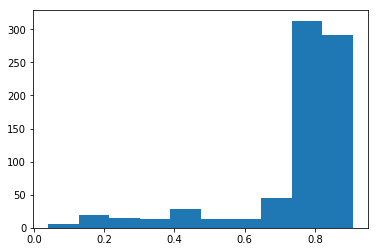

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df.PPE)

(array([ 25.,  44.,  82., 112., 109., 106., 106.,  83.,  68.,  21.]),
 array([0.5435  , 0.574414, 0.605328, 0.636242, 0.667156, 0.69807 ,
        0.728984, 0.759898, 0.790812, 0.821726, 0.85264 ]),
 <a list of 10 Patch objects>)

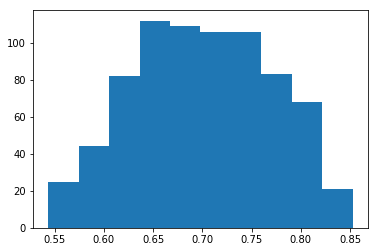

In [7]:
plt.hist(df.DFA)

(array([ 14.,  43., 103., 125., 149., 131.,  98.,  63.,  17.,  13.]),
 array([0.1543  , 0.225993, 0.297686, 0.369379, 0.441072, 0.512765,
        0.584458, 0.656151, 0.727844, 0.799537, 0.87123 ]),
 <a list of 10 Patch objects>)

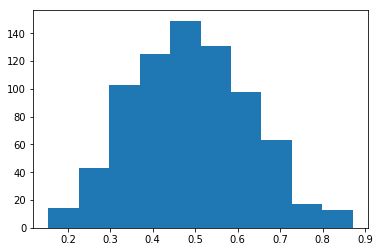

In [9]:
plt.hist(df.RPDE)

In [46]:
a = 0
for i in model.feature_importances_:
    print(df.columns[a] + "\t" + str(i))
    a = a + 1

gender	0.0
PPE	0.00015694908988868634
DFA	0.002551380769841453
RPDE	0.0
numPulses	0.0
numPeriodsPulses	0.003507106550144499
meanPeriodPulses	0.003652024489173481
stdDevPeriodPulses	0.0
locPctJitter	0.0
locAbsJitter	0.0025783232248507947
rapJitter	0.0
ppq5Jitter	0.0
ddpJitter	0.0
locShimmer	0.0
locDbShimmer	9.033055806575006e-05
apq3Shimmer	0.0
apq5Shimmer	0.0
apq11Shimmer	0.0036153604018582452
ddaShimmer	0.00023685625871127736
meanAutoCorrHarmonicity	0.0
meanNoiseToHarmHarmonicity	0.0
meanHarmToNoiseHarmonicity	0.0
minIntensity	0.007314038974625632
maxIntensity	0.0
meanIntensity	0.00012114194448752223
f1	0.0
f2	0.007164672111435273
f3	0.0
f4	0.0
b1	0.0006172053400870616
b2	0.001956797377946002
b3	0.00019115329927416118
b4	0.0005204670642981687
GQ_prc5_95	0.002024209411795995
GQ_std_cycle_open	0.0001447843221651639
GQ_std_cycle_closed	0.0
GNE_mean	0.0
GNE_std	0.00019252561126275147
GNE_SNR_TKEO	0.02365473425972571
GNE_SNR_SEO	0.0
GNE_NSR_TKEO	0.0008965598246167993
GNE_NSR_SEO	0.00015770

In [25]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(270,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
567/567 [==============================] - 6s 10ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 2/10
567/567 [==============================] - 4s 8ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 3/10
567/567 [==============================] - 5s 9ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 4/10
567/567 [==============================] - 4s 8ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 5/10
567/567 [==============================] - 5s 8ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 6/10
567/567 [==============================] - 5s 9ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 7/10
567/567 [==============================] - 4s 8ms/sample - loss: 4.0207 - acc: 0.7478 0s - loss: 4.0425 - acc: 0.746
Epoch 8/10
567/567 [==============================] - 4s 8ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 9/10
567/567 [==============================] - 5s 8ms/sample - loss: 4.0207 - acc: 0.7478
Epoch 10/10
189/189 [==============================] - 0s 2ms/sample - loss: 4.1332 - acc: 0.74